In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics import Accuracy
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
device = torch.device('mps')

## Custom Dataset

In [4]:
class CustomDogsCats(Dataset):
    def __init__(self, csv_file, root_directory, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_directory
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        labels = self.annotations.iloc[index, 1]
        image = Image.open(img_path).convert("RGB") 
        
        if self.transform:
            image = self.transform(image)
        
        return(image, labels)

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128, you can adjust size
    transforms.ToTensor()
])

In [6]:
dataset = CustomDogsCats(csv_file = "/Users/abhishekwaghchaure/Desktop/Datasets/big_cat_dog/cat_dog.csv",root_directory = "/Users/abhishekwaghchaure/Desktop/Datasets/big_cat_dog/cat_dog", transform = transform)

In [7]:
# Check the total number of records in the dataset
print(f"Total records in dataset: {len(dataset)}")

# Extract all labels
all_labels = [dataset[i][1] for i in range(len(dataset))]

# Get the distribution of each class
label_counts = Counter(all_labels)
print(f"Class distribution: {label_counts}")

Total records in dataset: 25000
Class distribution: Counter({1: 12500, 0: 12500})


In [8]:
label_map = {0: "Cat", 1: "Dog"}  # Adjust this based on your actual label meanings
mapped_label_counts = {label_map[label]: count for label, count in label_counts.items()}

print(f"Class distribution: {mapped_label_counts}")

Class distribution: {'Dog': 12500, 'Cat': 12500}


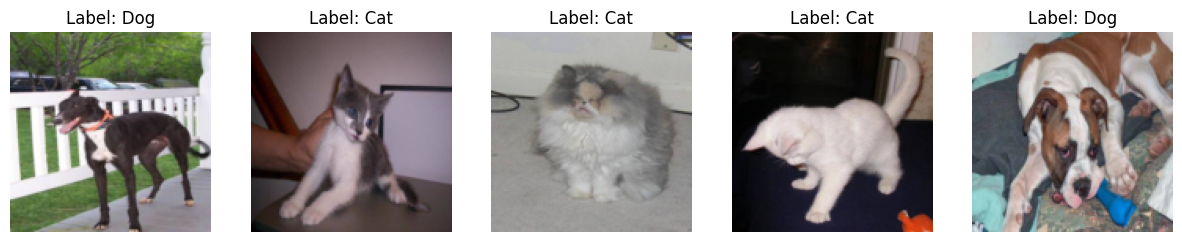

In [9]:

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image, label = dataset[i]
    label_name = label_map.get(label, label)  # Map label if possible
    axes[i].imshow(image.permute(1, 2, 0))  # Adjust if using torch tensors
    axes[i].set_title(f"Label: {label_name}")
    axes[i].axis("off")
plt.show()

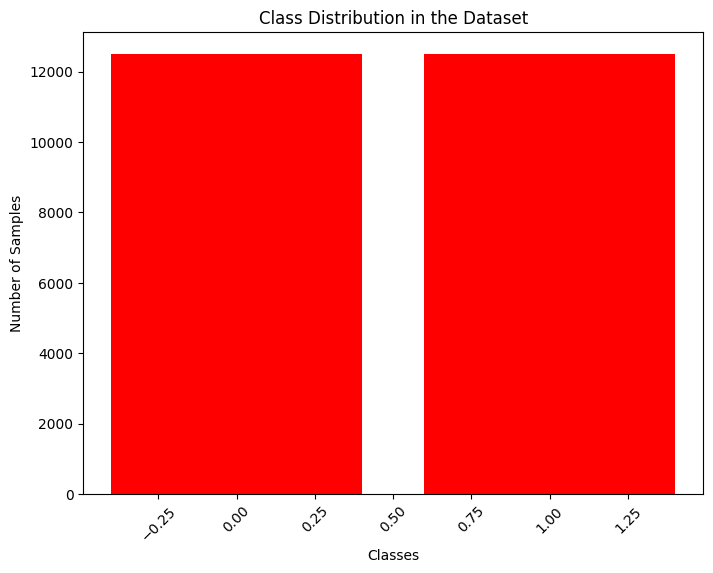

In [10]:
classes = label_counts.keys()
counts = label_counts.values()

plt.figure(figsize = (8,6))
plt.bar(classes,counts, color = 'red')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation = 45)
plt.show()

In [11]:
train_set, test_set = torch.utils.data.random_split(dataset,[20000,5000])

In [12]:
#hyperparameters
# input_size = 32
output_size = 1 # binary classifier 
epochs = 10
batch_size = 30
lr = 0.001

In [13]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle =True)
val_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle =False)

In [14]:
images, labels = next(iter(train_loader))

In [15]:
images.shape

torch.Size([30, 3, 128, 128])

In [16]:
labels.shape

torch.Size([30])

In [17]:
labels

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0])

## Model

In [18]:
images.shape

torch.Size([30, 3, 128, 128])

In [19]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=1,stride=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3),padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2,2),padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)) ##32 *32 *64
        )
        
        self.ann = nn.Sequential(
            nn.Linear((32 * 32 * 64), 120),
            nn.ReLU(),
            nn.Linear(120, output_size),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.cnn(x)
        x = x.view(x.shape[0],-1)
        x = self.ann(x)
        
        return x
        

## Training Loop

In [20]:
model = CustomCNN().to(device = device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)
acc =Accuracy(task = 'binary',threshold=0.5).to(device = device)

In [21]:
for epoch in range(epochs):
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    running_loss = 0.0
    for idx,(images,labels) in loop:
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        model.train()
        optimizer.zero_grad()
        
        output = model(images)
        labels = labels.unsqueeze(1).float()
        loss = criterion(output,labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        accuracy  = acc(output, labels)
        
        loop.set_description(f"Epoch : [{epoch}/{epochs}]")
        loop.set_postfix(loss =  loss.item(), accuracy = accuracy.item())
    
    ## print loss for each epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
        

Epoch : [0/10]: 100%|██████████| 667/667 [01:27<00:00,  7.64it/s, accuracy=0.45, loss=0.693] 


Epoch [1/10], Loss: 0.6932


Epoch : [1/10]: 100%|██████████| 667/667 [01:28<00:00,  7.57it/s, accuracy=0.6, loss=0.693]  


Epoch [2/10], Loss: 0.6931


Epoch : [2/10]: 100%|██████████| 667/667 [01:28<00:00,  7.56it/s, accuracy=0.5, loss=0.693]  


Epoch [3/10], Loss: 0.6931


Epoch : [3/10]: 100%|██████████| 667/667 [01:28<00:00,  7.56it/s, accuracy=0.6, loss=0.693]  


Epoch [4/10], Loss: 0.6931


Epoch : [4/10]: 100%|██████████| 667/667 [01:27<00:00,  7.58it/s, accuracy=0.45, loss=0.693] 


Epoch [5/10], Loss: 0.6931


Epoch : [5/10]: 100%|██████████| 667/667 [01:28<00:00,  7.55it/s, accuracy=0.5, loss=0.693]  


Epoch [6/10], Loss: 0.6931


Epoch : [6/10]: 100%|██████████| 667/667 [01:27<00:00,  7.61it/s, accuracy=0.55, loss=0.693] 


Epoch [7/10], Loss: 0.6931


Epoch : [7/10]: 100%|██████████| 667/667 [01:28<00:00,  7.56it/s, accuracy=0.3, loss=0.693]  


Epoch [8/10], Loss: 0.6931


Epoch : [8/10]: 100%|██████████| 667/667 [01:27<00:00,  7.58it/s, accuracy=0.65, loss=0.693] 


Epoch [9/10], Loss: 0.6931


Epoch : [9/10]: 100%|██████████| 667/667 [01:27<00:00,  7.59it/s, accuracy=0.6, loss=0.693]  

Epoch [10/10], Loss: 0.6931


In [22]:
# Validation Phase
model.eval()  # Set the model to evaluation mode
val_accuracy = Accuracy(task='binary', threshold=0.5).to(device=device)
val_loss = 0.0
with torch.no_grad():  # Disable gradient calculation for validation
    for epoch in range(epochs):
        val_loop = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Validation Epoch [{epoch + 1}/{epochs}]") 
        for val_idx, (val_images, val_labels) in val_loop:
            val_images = val_images.to(device=device)
            val_labels = val_labels.to(device=device)
    
            val_output = model(val_images)
            val_labels = val_labels.unsqueeze(1).float()  # Ensure labels shape is correct
    
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss.item()
            val_accuracy.update(val_output, val_labels)  # Update accuracy metric
    
            # Update progress bar with current validation loss and accuracy
            val_loop.set_postfix(val_loss=v_loss.item(), val_accuracy=val_accuracy.compute().item())

Validation Epoch [10/10]: 100%|██████████| 167/167 [00:11<00:00, 15.07it/s, val_accuracy=0.505, val_loss=0.693]


## Testing on images

In [23]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize all images to 128x128, you can adjust size
#     transforms.ToTensor()
# ])

image_path = "/Users/abhishekwaghchaure/Downloads/Unknown"
image = Image.open(image_path).convert("RGB")
image = transform(image)
image.unsqueeze(0) ## Batch dimension
image.to(device = device)

tensor([[[0.7294, 0.7294, 0.7294,  ..., 0.7529, 0.7490, 0.7529],
         [0.7294, 0.7294, 0.7294,  ..., 0.7569, 0.7529, 0.7608],
         [0.7294, 0.7294, 0.7294,  ..., 0.7647, 0.7608, 0.7647],
         ...,
         [0.7373, 0.7373, 0.7373,  ..., 0.7569, 0.7490, 0.7725],
         [0.7412, 0.7373, 0.7333,  ..., 0.7647, 0.7490, 0.7686],
         [0.7373, 0.7373, 0.7373,  ..., 0.7725, 0.7686, 0.7686]],

        [[0.7490, 0.7490, 0.7490,  ..., 0.7725, 0.7686, 0.7725],
         [0.7490, 0.7490, 0.7490,  ..., 0.7765, 0.7725, 0.7804],
         [0.7490, 0.7490, 0.7490,  ..., 0.7843, 0.7804, 0.7843],
         ...,
         [0.7569, 0.7569, 0.7569,  ..., 0.7647, 0.7569, 0.7804],
         [0.7608, 0.7569, 0.7529,  ..., 0.7725, 0.7569, 0.7765],
         [0.7569, 0.7569, 0.7569,  ..., 0.7804, 0.7765, 0.7765]],

        [[0.7333, 0.7333, 0.7333,  ..., 0.7490, 0.7451, 0.7490],
         [0.7333, 0.7333, 0.7333,  ..., 0.7529, 0.7490, 0.7569],
         [0.7333, 0.7333, 0.7333,  ..., 0.7608, 0.7569, 0.

In [62]:
model.eval()
with torch.no_grad():
    model = model.to(device = device)
    image = image.to(device = device)
    image = image.squeeze(1)  # Adds a batch dimension if it's a single image
    output = model(image)
    # Convert prediction to a float after applying sigmoid
    prediction = torch.sigmoid(output).item()

In [63]:
predicted_class = 1 if prediction >= 0.5 else 0
label_map = {0: "Cat", 1: "Dog"} 
print(f"Predicted class: {label_map[predicted_class]} with confidence {prediction:.4f}")

Predicted class: Dog with confidence 0.5000


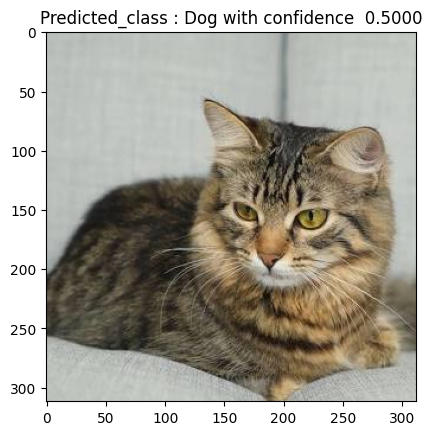

In [64]:
plt.imshow(Image.open(image_path))
plt.title(f"Predicted_class : {label_map[predicted_class]} with confidence {prediction: .4f}")
plt.show()